In [1]:
%matplotlib inline
import glob as glob
import numpy as np


import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

from sklearn.metrics import average_precision_score, precision_recall_curve
h = .02  # step size in the mesh


In [2]:
def split_data(files, test_percent = .33):
    #randomly pick test_percent of folders
    num = len(files)
    test_list = int(test_percent*num)
    rand_index = np.arange(0, num)
    np.random.shuffle(rand_index)
    
    XY_Train = list()
    XY_Test = list()    

    # train set
    for k in rand_index[test_list:]:
      Xy_tr = np.load(files[k])              
      if len(XY_Train) == 0:
        XY_Train = Xy_tr
      else:
        XY_Train = np.append(XY_Train, Xy_tr, axis =0)
    # test set
    
    for  k in rand_index[:test_list]:
      Xy_ts = np.load(files[k])        
      if len(XY_Test) == 0:
        XY_Test = Xy_ts
      else:
        XY_Test = np.append(XY_Test, Xy_ts, axis =0)    
    return XY_Train, XY_Test

In [3]:
data_files = '.'
all_files = glob.glob(data_files+'/*.npy')
all_files = all_files[:4]

Automatically created module for IPython interactive environment
Average precision-recall score: 0.01 for Nearest Neighbors
Average precision-recall score: 0.02 for Linear SVM
Average precision-recall score: 0.08 for RBF SVM
Average precision-recall score: 0.04 for Decision Tree
Average precision-recall score: 0.28 for Random Forest
Average precision-recall score: 0.02 for Neural Net
Average precision-recall score: 0.07 for AdaBoost
Average precision-recall score: 0.02 for Naive Bayes


/home/charley/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Average precision-recall score: 0.01 for QDA


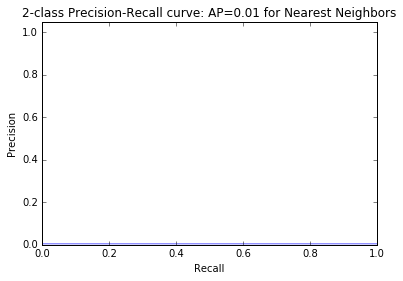

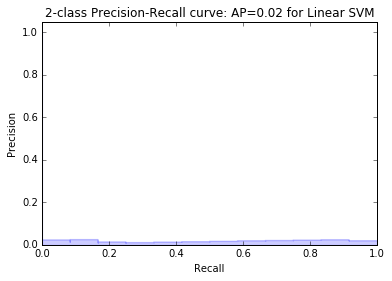

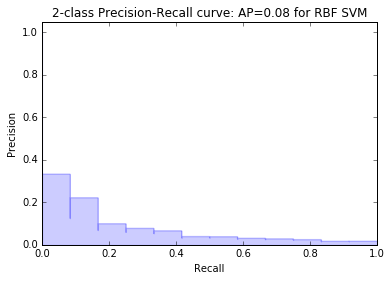

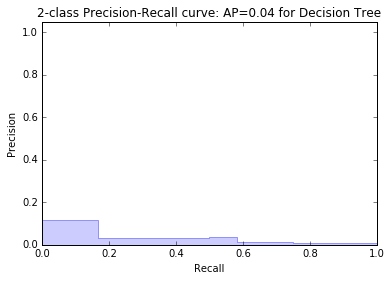

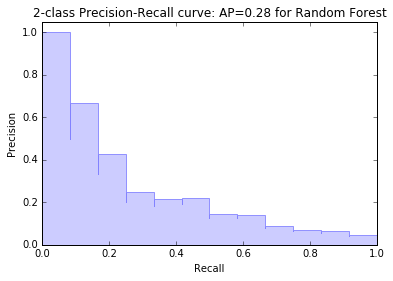

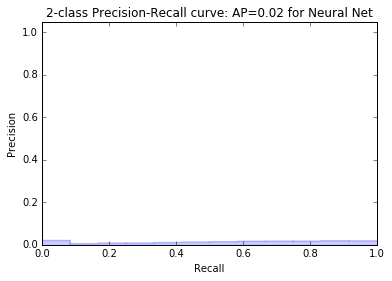

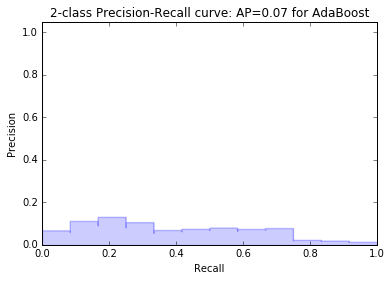

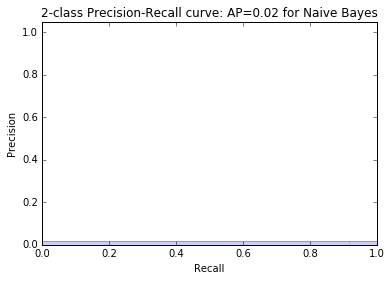

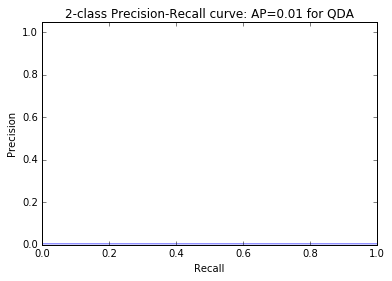

In [4]:
print(__doc__)


# Code source: Gaël Varoquaux
#              Andreas Müller
# Modified for documentation by Jaques Grobler
# License: BSD 3 clause

# names = ["Nearest Neighbors", "Linear SVM", "RBF SVM", "Gaussian Process",
#          "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
#          "Naive Bayes", "QDA"]
names = [
    "Nearest Neighbors",
        "Linear SVM",
        "RBF SVM",
         "Decision Tree",
        "Random Forest", "Neural Net", "AdaBoost",
         "Naive Bayes", 
        "QDA"]

# classifiers = [
#     KNeighborsClassifier(3),
#     SVC(kernel="linear", C=0.025),
#     SVC(gamma=2, C=1),
#     GaussianProcessClassifier(1.0 * RBF(1.0)),
#     DecisionTreeClassifier(max_depth=5),
#     RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
#     MLPClassifier(alpha=1),
#     AdaBoostClassifier(),
#     GaussianNB(),
#     QuadraticDiscriminantAnalysis()]

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()]


# iterate over datasets
img_dim = (28,28)

XY_Train_All, XY_Test_ALL= split_data(all_files, test_percent=.33)
X_train, y_train = XY_Train_All[:, :img_dim[0]**2], XY_Train_All[:, img_dim[0]**2]
X_test, y_test = XY_Test_ALL[:, :img_dim[0]**2], XY_Test_ALL[:, img_dim[0]**2] 

for name, clf in zip(names, classifiers):
    clf.fit(X_train, y_train)  
    if hasattr(clf, "predict_proba"):
        prob_pos = clf.predict_proba(X_test)[:, 1]
    else:  # use decision function
        prob_pos = clf.decision_function(X_test)
        prob_pos = (prob_pos - prob_pos.min()) / (prob_pos.max() - prob_pos.min())
    average_precision = average_precision_score(y_test, prob_pos)
    print('Average precision-recall score: {0:0.2f} for {1:s}'.format(average_precision, name))
    precision, recall, _ = precision_recall_curve(y_test, prob_pos)
    
    plt.figure()
    plt.step(recall, precision, color='b', alpha=0.2,where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='b')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('2-class Precision-Recall curve: AP={0:0.2f} for {1:s}'.format(average_precision, name))


In [5]:
def split_train_test(X, y, n_labeled, test_size = .33):
    X_train, X_test, y_train, y_test = \
        train_test_split(X, y, test_size=test_size)
    
    while len(np.unique(y_train[:n_labeled])) < 2:
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.33)
    
    trn_ds = Dataset(X_train, np.concatenate(
        [y_train[:n_labeled], [None] * (len(y_train) - n_labeled)]))
    tst_ds = Dataset(X_test, y_test)
    fully_labeled_trn_ds = Dataset(X_train, y_train)

    return trn_ds, tst_ds, y_train, fully_labeled_trn_ds


In [6]:
def run(trn_ds, tst_ds, lbr, model, qs, quota):
    AP = []

    for _ in range(quota):
        # Standard usage of libact objects
        ask_id = qs.make_query()
        X, _ = zip(*trn_ds.data)
        lb = lbr.label(X[ask_id])
        trn_ds.update(ask_id, lb)

        model.train(trn_ds)
        if hasattr(model, "predict_proba"):
            prob_pos = clf.predict_proba(X_test)[:, 1]
        else:  # use decision function
            prob_pos = clf.decision_function(X_test)
            prob_pos = (prob_pos - prob_pos.min()) / (prob_pos.max() - prob_pos.min())
        average_precision = average_precision_score(y_test, prob_pos)       
        
#         AP = np.append(AP, average_precision)
    return AP


In [7]:
try:
    from sklearn.model_selection import train_test_split
except ImportError:
    from sklearn.cross_validation import train_test_split

# libact classes
from libact.base.dataset import Dataset, import_libsvm_sparse
from libact.models import *
from libact.query_strategies import *
from libact.labelers import IdealLabeler
import copy

X = np.append(X_train, X_test, axis = 0)
y = np.append(y_train, y_test, axis = 0)

n_labeled = 20
# Load dataset    
  
print (X.shape)
print (y.shape)
for name, clf in zip(names, classifiers):
    trn_ds, tst_ds, y_train, fully_labeled_trn_ds = split_train_test(X,y, n_labeled)

    trn_ds2 = copy.deepcopy(trn_ds)
    lbr = IdealLabeler(fully_labeled_trn_ds)

    quota = len(y_train) - n_labeled    # number of samples to query

    # Comparing UncertaintySampling strategy with RandomSampling.
    # model is the base learner, e.g. LogisticRegression, SVM ... etc.
    qs = UncertaintySampling(trn_ds, method='lc', model=LogisticRegression())
    model = LogisticRegression()
    E_in_1, E_out_1 = run(trn_ds, tst_ds, lbr, model, qs, quota)

    qs2 = RandomSampling(trn_ds2)
    model = LogisticRegression()
    AP = run(trn_ds2, tst_ds, lbr, model, qs2, quota)
    plt.figure()
    plt.plot(AP)
    break
# Plot the learning curve of UncertaintySampling to RandomSampling
# The x-axis is the number of queries, and the y-axis is the corresponding
# error rate.
# query_num = np.arange(1, quota + 1)
# plt.plot(query_num, E_in_1, 'b', label='qs Ein')
# plt.plot(query_num, E_in_2, 'r', label='random Ein')
# plt.plot(query_num, E_out_1, 'g', label='qs Eout')
# plt.plot(query_num, E_out_2, 'k', label='random Eout')
# plt.xlabel('Number of Queries')
# plt.ylabel('Error')
# plt.title('Experiment Result')
# plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
#            fancybox=True, shadow=True, ncol=5)
# plt.show()


(6758, 784)
(6758,)


KeyboardInterrupt: 